In [1]:
#@title **Libraries**

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "whitegrid", context = "notebook")

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer, MinMaxScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import mean_squared_error, r2_score

# Import data

In [2]:
%%capture
!curl -L -o ./loan-approval-classification-data.zip\
  https://www.kaggle.com/api/v1/datasets/download/arjunnagesh/insurance
!unzip loan-approval-classification-data.zip; rm loan-approval-classification-data.zip

In [3]:
df = pd.read_csv("insurance.csv")

# Exploratory Data Analysis

## Basic Analysis

In [ ]:
df.sample(5)

,age,sex,bmi,children,smoker,region,charges
158,30,male,35.530,0,yes,southeast,36950.2567
106,19,female,28.400,1,no,southwest,2331.5190
648,18,male,28.500,0,no,northeast,1712.2270
814,36,male,34.430,2,no,southeast,5584.3057
128,32,female,17.765,2,yes,northwest,32734.1863


Columns descriptions:
* Age: How old the patient is
* Sex: Female or Male
* BMI: Body Mass Index. It measures the ratio of the height to the weight to estimate the amount of body fat the patient has
* Children: How many children the patient has
* Smoker: Is the patient an active smoker?
* Region: The region where the patient lives
* Charges: How much the patient was charged for the medical expenses

In [ ]:
#How many rows and columns does the data set has?
df.shape

(1338, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The `info` method shows no column has null values, since the number of non-null values is equal to the number of entries in the data set. In the other hand, there are three columns with `object` as their data type

In [ ]:
#is there any duplicates in the data?
df.duplicated().sum() != 0

True

In [ ]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [ ]:
#let's drop the duplicates
df.drop_duplicates(inplace = True)

In [ ]:
df_summary_stats = df.describe()
df_summary_stats

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


## Univariative Analysis

### Age

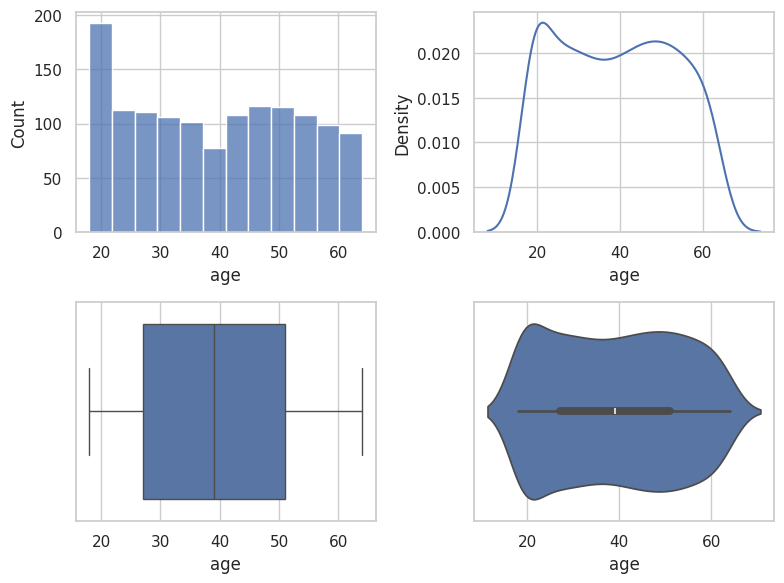

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8,6))
sns.histplot(data = df, x = "age", ax = axes[0][0])
sns.kdeplot(data = df, x = "age", ax = axes[0][1])
sns.boxplot(data = df, x = "age", ax = axes[1][0])
sns.violinplot(data = df, x = "age", ax = axes[1][1])
plt.tight_layout()
plt.show()

By looking at the boxplot outliers. The histogram shows that the age range with the most people correspond to the first bin of this chart, specifically people aged between 18 and 21

In [ ]:
df.age.value_counts(bins = 12).iloc[:1]

,count
"(17.953, 21.833]",194


In [ ]:
df_summary_stats["age"].to_frame().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0,27.0,39.0,51.0,64.0


The mean and the median are really close, indicating that the data might not be heavily skewed. Let's test that statement

In [ ]:
#Given that the skewness is close to 0, this is another indication the data is not heavily skewed
stats.skew(df.age)

0.054719294607049676

### BMI

In [ ]:
df_summary_stats["bmi"].to_frame().T

,count,mean,std,min,25%,50%,75%,max
bmi,1337.0,30.663452,6.100468,15.96,26.29,30.4,34.7,53.13


In [ ]:
iqr_bmi = df.bmi.quantile(0.75) - df.bmi.quantile(0.25)
iqr_bmi

8.410000000000004

The IQR, plus the std, show that the data is concentrated in a relatively small range

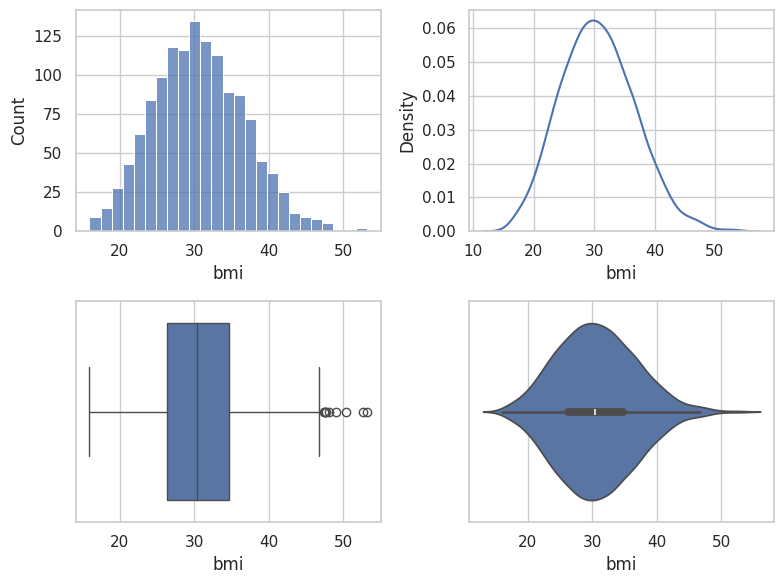

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8,6))
sns.histplot(data = df, x = "bmi", ax = axes[0][0])
sns.kdeplot(data = df, x = "bmi", ax = axes[0][1])
sns.boxplot(data = df, x = "bmi", ax = axes[1][0])
sns.violinplot(data = df, x = "bmi", ax = axes[1][1])
plt.tight_layout()
plt.show()

The `bmi` histogram and kde show that this variables follows a normal distribution. This might be attributed to the fact that both weight and height follow this distribution as well, and since bmi is a ratio of these two, then this behaviour is expected.

The boxplot and violinplot show that there are some outliers, let's use the IQR method to spot them

In [ ]:
bmi_upper_limit = df.bmi.quantile(0.75) + iqr_bmi * 1.5

df[df.bmi > bmi_upper_limit]

,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
847,23,male,50.38,1,no,southeast,2438.05520
860,37,female,47.60,2,yes,southwest,46113.51100
1047,22,male,52.58,1,yes,southeast,44501.39820
1088,52,male,47.74,1,no,southeast,9748.91060
1317,18,male,53.13,0,no,southeast,1163.46270


### Charges

In [ ]:
df_summary_stats["charges"].to_frame().T

,count,mean,std,min,25%,50%,75%,max
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [ ]:
iqr_charges = df.charges.quantile(0.75) - df.charges.quantile(0.25)
iqr_charges

11911.37345

The mean is much greater than the median. This is indicates that there is a chance that the data is skewed. Also the IQR is large, which shows that we have a wide range of values

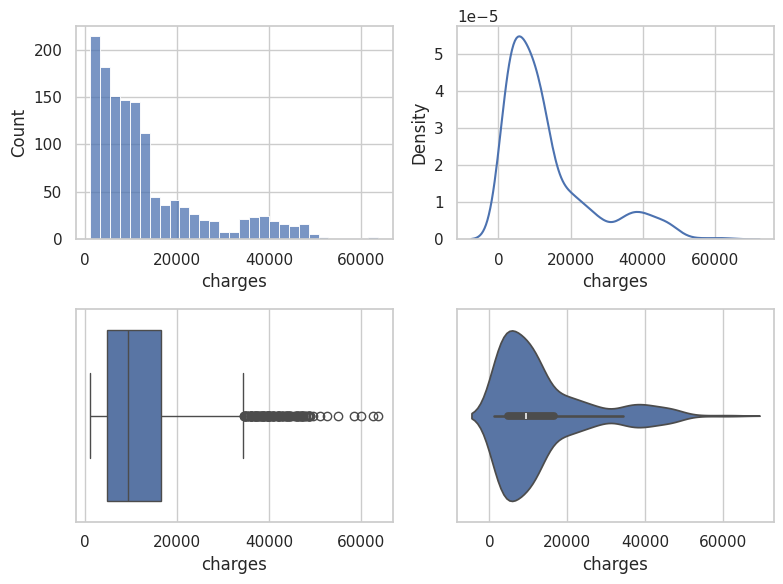

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8,6))
sns.histplot(data = df, x = "charges", ax = axes[0][0])
sns.kdeplot(data = df, x = "charges", ax = axes[0][1])
sns.boxplot(data = df, x = "charges", ax = axes[1][0])
sns.violinplot(data = df, x = "charges", ax = axes[1][1])
plt.tight_layout()
plt.show()

The histogram shows the data is skewed to the right. The boxplot shows a high number of outliers, and we can confirm this by looking at the other charts, the data has a tendency to be lower and lower until it gets to a charge around 35k, from that point on, we see an increase in the number of high charges. Let's use the IQR method to see how many outliers there are

In [ ]:
charges_upper_limit = df.charges.quantile(0.75) + iqr_charges * 1.5
print(f"Charges above {charges_upper_limit:.2f} will be considered as outliers")

df[df.charges > charges_upper_limit]

Charges above 34524.78 will be considered as outliers


,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


There are 139 patients that have charges that are atypical in the data set. These patients average charges of

In [ ]:
df[df.charges > charges_upper_limit].charges.mean().round(2)

42103.95

Finally, let's confirm if the data is skewed

In [ ]:
#The data is skewed to the left
df.charges.agg(["skew"])

,charges
skew,1.51588


### Sex

In [ ]:
df.sex.value_counts(normalize = True).round(4)*100

,proportion
sex,
male,50.49
female,49.51


This class is well balanced, since we have an almost even split for female and male

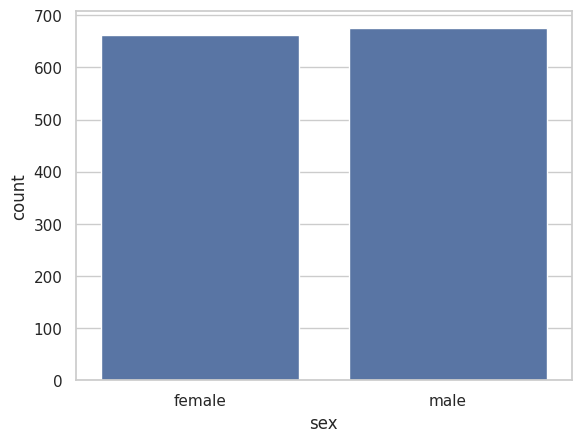

In [ ]:
sns.countplot(data = df, x = "sex")
plt.show()

### Smoker

In [ ]:
df.smoker.value_counts(normalize = True).round(4)*100

,proportion
smoker,
no,79.51
yes,20.49


Almost 80% of the patients are not smokers. Here we see that classes are unbalanced, since the number of observations for smokers is 1/4 of the observations of non-smokers

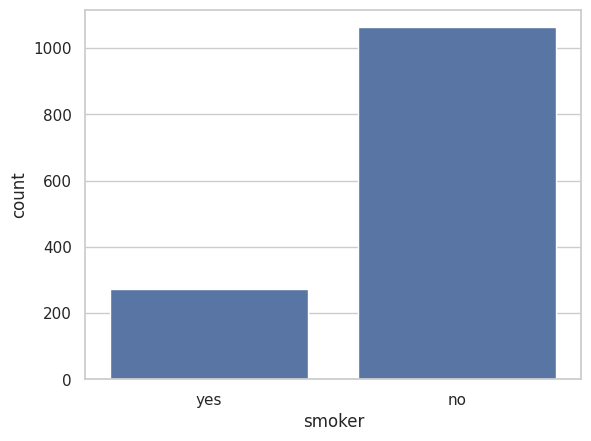

In [ ]:
sns.countplot(data = df, x = "smoker")
plt.show()

### Region

In [ ]:
df.region.value_counts(normalize = True).round(4)*100

,proportion
region,
southeast,27.23
southwest,24.31
northwest,24.23
northeast,24.23


The classes are well balanced

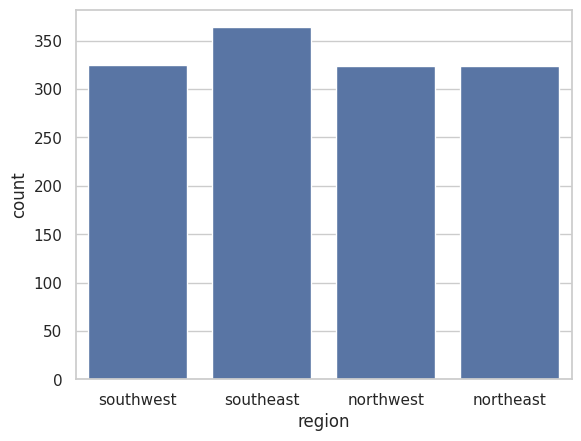

In [ ]:
sns.countplot(data = df, x = "region")
plt.show()

### Children

In [ ]:
df.children.value_counts(normalize = True).round(4)*100

,proportion
children,
0,42.90
1,24.22
2,17.94
3,11.73
4,1.87
5,1.35


More than $42\%$ of the population in the data set have got no children.

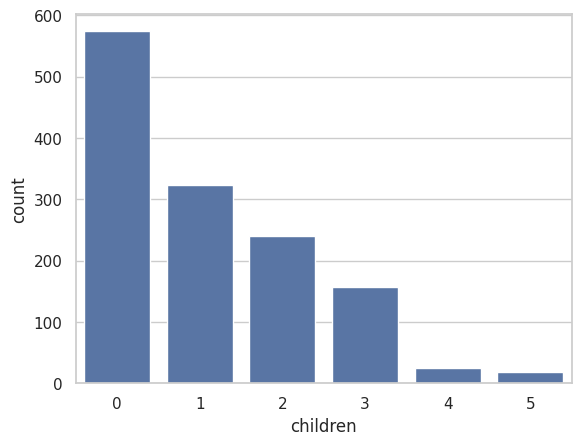

In [ ]:
sns.countplot(data = df, x = "children")
plt.show()

In [ ]:
df.children.mean()

1.0949177877429

On average there is 1 child per patient

Given that patients with 3, 4 and 5 children do not represent a significant percentage in the data, they will be grouped together as "3+"

In [ ]:
df_copy = df.copy()
more_than_3_children_idx = df_copy[df_copy.children >= 3].index
df_copy["children"] = df.children.astype(str)
df_copy.loc[more_than_3_children_idx, "children"] = "3+"

In [ ]:
df_copy.children.value_counts(normalize = True).round(4)*100

,proportion
children,
0,42.90
1,24.22
2,17.94
3+,14.95


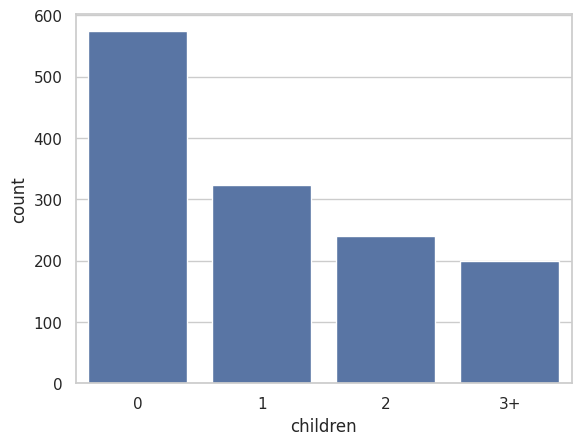

In [ ]:
sns.countplot(data = df_copy, x = "children", order = ["0","1","2","3+"])
plt.show()

## Bivariative Analysis

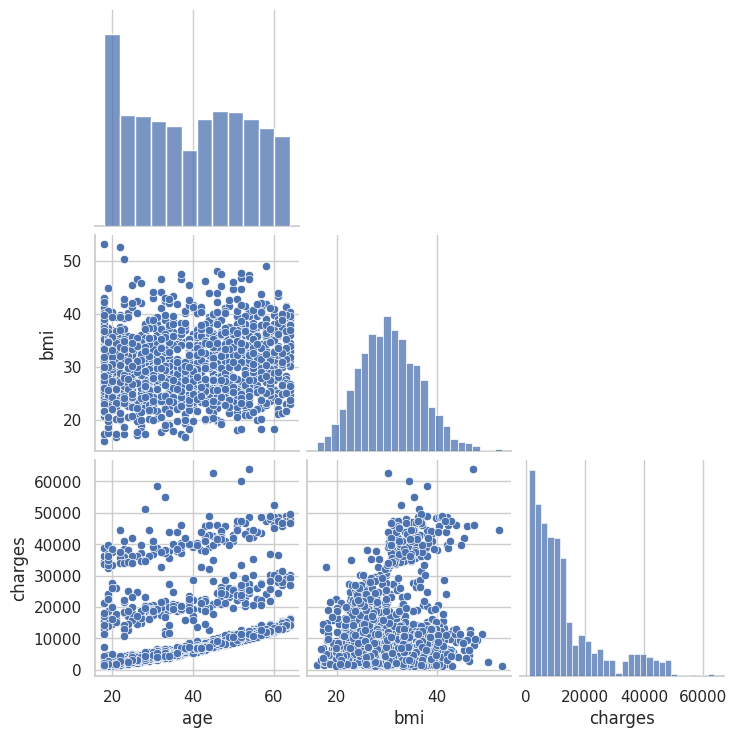

In [ ]:
sns.pairplot(df_copy[["age", "bmi", "charges"]], corner=True)
plt.show()

* In general as age is higher, so are the charges, but there are like three groups, between 0 and around 17k in charges there is one group, for the second group there are charges between 12k and 32k there is another group and finally between 32k and 50k there is the third group
* BMI looks like it increases as charges do

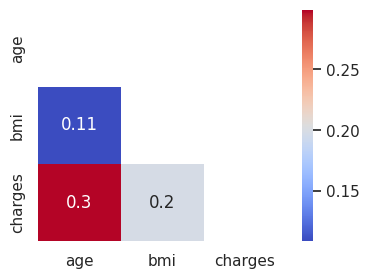

In [ ]:
plt.figure(figsize = (4,3))
sns.set_theme(style = "white")
sns.heatmap(df_copy[["age", "bmi", "charges"]].corr(), annot = True, cmap = "coolwarm", mask = np.triu(np.ones((3,3))))
plt.show()

Correlation matrix shows no strong relationships between variables

In [ ]:
vif_data = pd.DataFrame()
num_cols = df_copy.select_dtypes(exclude = "object").columns
vif_data["Variable"] = num_cols
vif_data["VIF"] = [variance_inflation_factor(df_copy[num_cols].values, i) for i in range(len(num_cols))]

print(vif_data)

  Variable       VIF
0      age  8.035978
1      bmi  7.679282
2  charges  2.468882


We've got no VIF higher than 10, meaning there is no clear colinearity in the data, which fits with the observations made from the correlation matrix and the scatterplots

For the statistical significance test, we'll set the threshold to 0.05

In [ ]:
stats.f_oneway(df_copy[df_copy.sex == "male"]["charges"], df_copy[df_copy.sex == "female"]["charges"])

F_onewayResult(statistic=4.3997016974374565, pvalue=0.03613272100596256)

<Axes: xlabel='charges', ylabel='Count'>

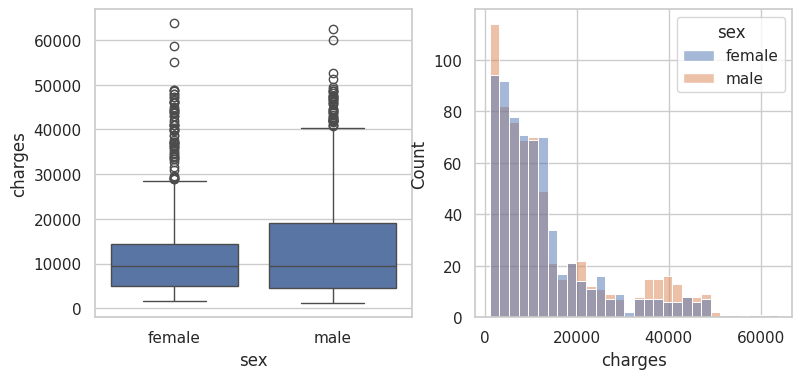

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (9,4))
sns.boxplot(data = df_copy, x = "sex", y = "charges", ax = axes[0])
sns.histplot(data = df_copy, x = "charges", hue = "sex", ax = axes[1], multiple="layer")

In [ ]:
stats.f_oneway(df_copy[df_copy.children == "0"]["charges"],
               df_copy[df_copy.children == "1"]["charges"],
               df_copy[df_copy.children == "2"]["charges"],
               df_copy[df_copy.children == "3+"]["charges"],
               )

F_onewayResult(statistic=3.8544149183968988, pvalue=0.00923177101361197)

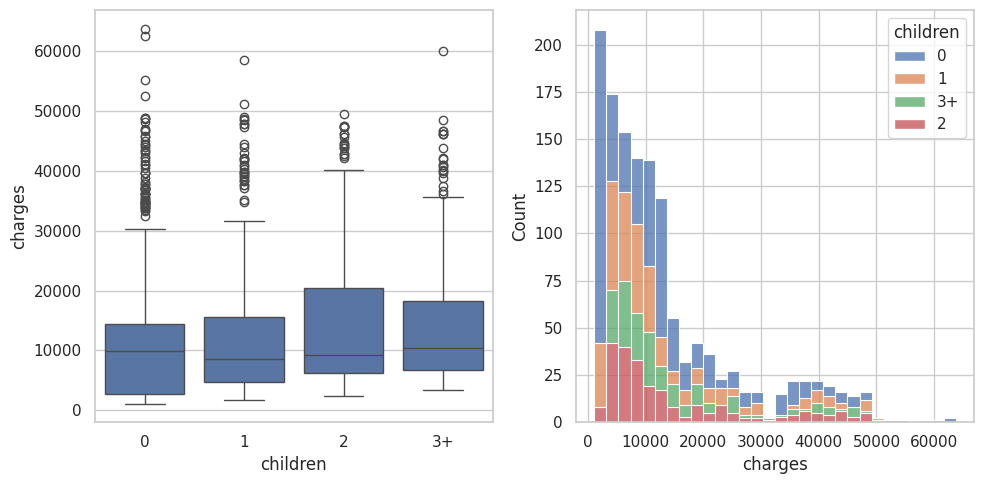

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
sns.boxplot(data = df_copy, x = "children", y = "charges", ax = axes[0], order=["0","1","2","3+"])
sns.histplot(data = df_copy, x = "charges", hue = "children", ax = axes[1], multiple="stack")
plt.tight_layout()

In [ ]:
df_copy.groupby("children").charges.mean().round(2)

,charges
children,
0,12365.98
1,12731.17
2,15073.56
3+,14576.00


In [ ]:
stats.f_oneway(df_copy[df_copy.smoker == "yes"]["charges"],
               df_copy[df_copy.smoker == "no"]["charges"])

F_onewayResult(statistic=2177.614868056519, pvalue=8.271435842182967e-283)

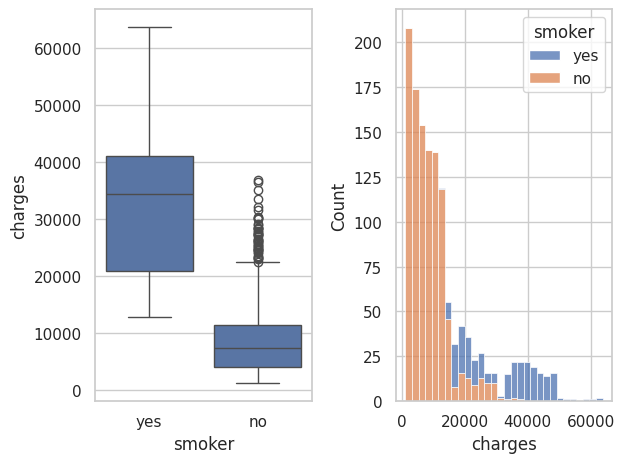

In [ ]:
fig, axes = plt.subplots(1,2)
sns.boxplot(data = df_copy, x = "smoker", y = "charges", ax = axes[0])
sns.histplot(data = df_copy, x = "charges", hue = "smoker", ax = axes[1], multiple="stack")
plt.tight_layout()

In [ ]:
df_copy[df_copy.smoker == "yes"]["charges"].mean()/df_copy[df_copy.smoker == "no"]["charges"].mean()

3.800001458298317

In [ ]:
stats.f_oneway(df_copy[df_copy.region == "southeast"]["charges"],
               df_copy[df_copy.region == "southwest"]["charges"],
               df_copy[df_copy.region == "northeast"]["charges"],
               df_copy[df_copy.region == "northwest"]["charges"]
               )

F_onewayResult(statistic=2.9696266935891193, pvalue=0.0308933560705201)

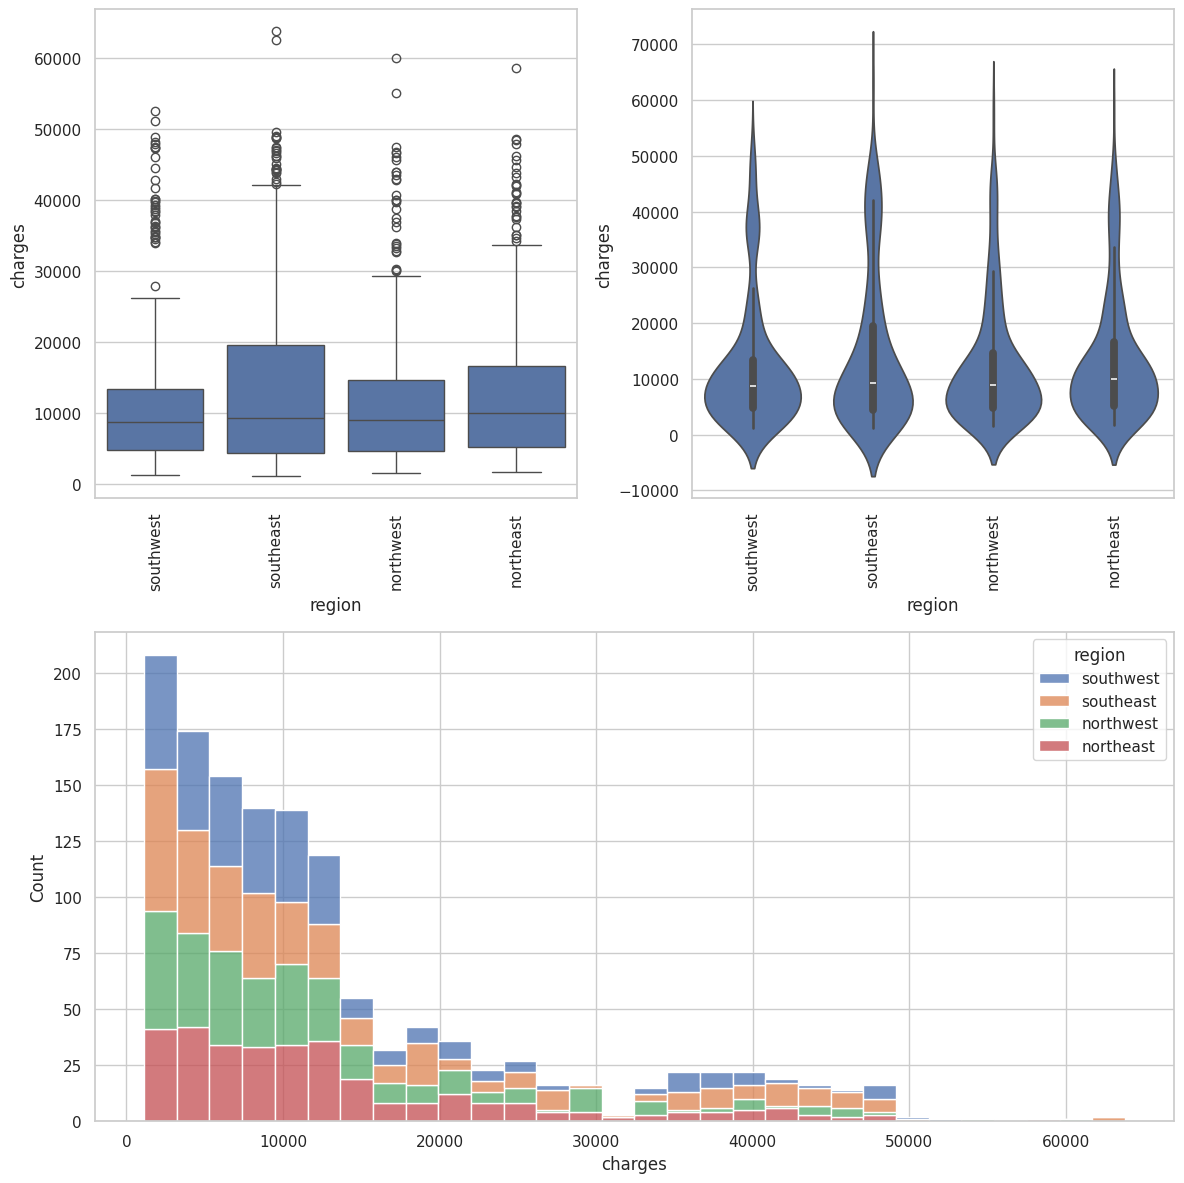

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1]})
sns.boxplot(data=df_copy, x="region", y="charges", ax=axes[0, 0])
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=90)
sns.violinplot(data=df_copy, x="region", y="charges", ax=axes[0, 1])
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=90)

fig.delaxes(axes[1, 0])
fig.delaxes(axes[1, 1])

ax_big = fig.add_subplot(2, 1, 2)  # Row 2, only one column
sns.histplot(data=df_copy, x="charges", hue="region", ax=ax_big, multiple="stack")

# Ajustar espacios
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()

plt.show()

In [ ]:
df_copy.groupby("region").charges.mean().round(2)

,charges
region,
northeast,13406.38
northwest,12417.58
southeast,14735.41
southwest,12346.94


The ANOVA test for each categorical variable vs the charges variable showed that
* `sex` had an F-statistic of 4.4 and a p-value of 0.03. The F-statistic is not that high but the p-value is below 0.05. After plotting `charges` using `sex` as hue, we saw little differences in terms of the median, but the data do seem more spred for the male observations, plus higher high charges are more like to be male-related
* `children` had a low f-statistic but its p-value is really low. When looking at the boxplots, we see that people with two children are likely to have higher charges.
* `smoker` has a really high f-statistic, and its p-value was extremely low. As one might have expected, smokers have higher medical expenses, and both boxplot and histogram confirm this. In fact smokers have average expenses that are 4 times higher the average expenses of a non-smoker
* `region` has a low f-statistic and a p-value that is close to our threshold of 0.05. Both boxplot and violinplot show that people from the east have, on average, higher medical charges.

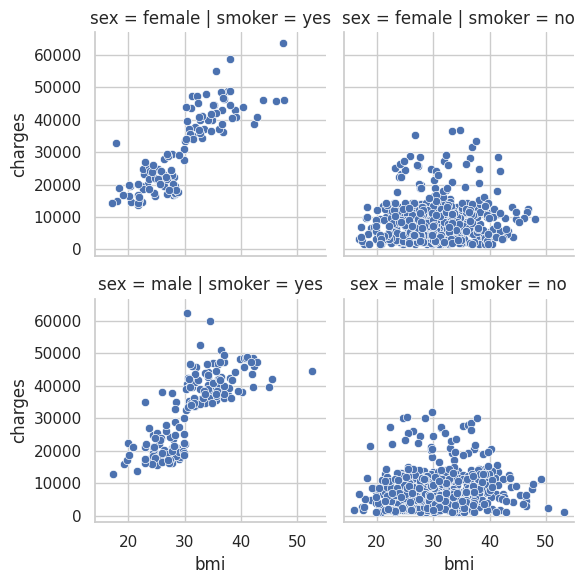

In [ ]:
g = sns.FacetGrid(df_copy, col="smoker",  row="sex")
g.map(sns.scatterplot, "bmi", "charges")
plt.show()

* Here we see that people that smoke will have higher charges, even though they have a similar bmi to non-smokers

# Model experimenting

In [ ]:
#@title Data transformation
df_copy = df.copy()
more_than_3_children_idx = df_copy[df_copy.children >= 3].index
df_copy["children"] = df.children.astype(str)
df_copy.loc[more_than_3_children_idx, "children"] = "3+"
new_df = df_copy.copy()

sex_encoder = LabelEncoder()
smoker_encoder = LabelEncoder()
region_encoder = LabelEncoder()
children_encoder = LabelEncoder()

new_df["sex"] = sex_encoder.fit_transform(new_df["sex"])
new_df["smoker"] = smoker_encoder.fit_transform(new_df["sex"])
new_df["region"] = region_encoder.fit_transform(new_df["region"])
new_df["children"] = children_encoder.fit_transform(new_df["children"])

In [ ]:
X = new_df.drop(columns = "charges")
y = new_df.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
#@title `calculate_metrics` function

def calculate_metrics(model, model_name ,X_train, X_test, y_train, y_test, results = None):
  preds_train = model.predict(X_train)
  preds_test = model.predict(X_test)
  r2_train = round(r2_score(y_train, preds_train),4)
  r2_test = round(r2_score(y_test, preds_test),4)
  mean_squared_error_train = round(mean_squared_error(y_train, preds_train),4)
  mean_squared_error_test = round(mean_squared_error(y_test, preds_test),4)
  if results is not None:
    results.loc[len(results)] = [model_name, r2_train, r2_test, mean_squared_error_train, mean_squared_error_test]
    return results
  return {"model_name": model_name, "r2_train":r2_train, "r2_test":r2_test, "mse_train":mean_squared_error_train, "mse_test":mean_squared_error_test}

In [ ]:
results = pd.DataFrame(columns = ["model", "r2_train", "r2_test", "mse_train", "mse_test"])

### Experiment 1

We'll use all variables of the data set

In [ ]:
X_train_intercept = sm.add_constant(X_train)
X_test_intercept = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train_intercept).fit()
print(model.summary().tables[0])
print(model.summary().tables[1])

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     27.68
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           2.63e-26
Time:                        21:34:12   Log-Likelihood:                -10783.
No. Observations:                1003   AIC:                         2.158e+04
Df Residuals:                     997   BIC:                         2.161e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7187.6639   2079.296     -3.457      0.0

In [ ]:
results = calculate_metrics(model, "Experiment 1: Fitting lin-reg with all predictors",X_train_intercept, X_test_intercept, y_train, y_test, results)

In [ ]:
results.iloc[0,:]

,0
model,Experiment 1: Fitting lin-reg with all predictors
r2_train,0.1219
r2_test,0.1351
mse_train,127403726.6185
mse_test,130503945.0725


We've got a low $R^2$ metric for both train and test sets. MSE is really high, but that is because `charges` variable has high values

## Experiment 2

We'll fit a model with the variables that showed statistical significance (p-value < 0.05) in Experiment 1. Those variables are:
* `age`
* `bmi`
* `children `

The other variables will be dropped

In [ ]:
X = new_df.drop(columns = ["charges", "sex","smoker", "region"])
y = new_df.charges
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
X_train_intercept = sm.add_constant(X_train)
X_test_intercept = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train_intercept).fit()
print(model.summary().tables[0])
print(model.summary().tables[1])

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     44.90
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           3.19e-27
Time:                        21:34:12   Log-Likelihood:                -10784.
No. Observations:                1003   AIC:                         2.158e+04
Df Residuals:                     999   BIC:                         2.160e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6847.1396   2038.898     -3.358      0.0

In [ ]:
results = calculate_metrics(model, "Experiment 2: Fitting lin-reg with significant predictors",X_train_intercept, X_test_intercept, y_train, y_test, results)

In [ ]:
results

,model,r2_train,r2_test,mse_train,mse_test
0,Experiment 1: Fitting lin-reg with all predictors,0.1219,0.1351,1.274037e+08,1.305039e+08
1,Experiment 2: Fitting lin-reg with significant...,0.1188,0.1284,1.278516e+08,1.315138e+08


The model performed a little worse, though it got similar results with less variables!

## Experiment 3

Scaling the data. We'll use the following transformations:

* Age ⟶ `MinMaxScaler`
* BMI ⟶ `StandardScaler`
* Charges' ⟶ `PowerTransformer`

In [ ]:
X = new_df.drop(columns = "charges")
y = new_df.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
cat_variables = ["sex", "children", "smoker", "region"]

In [ ]:
features_minmax = ["age"]
features_std = ["bmi"]

minmax_transformer = Pipeline([
    ("min_max_scaler", MinMaxScaler())
])

std_transformer = Pipeline([
    ("standard_scaler", StandardScaler())
])

transformer = ColumnTransformer([
    ("minmax", minmax_transformer, features_minmax),
    ("std", std_transformer, features_std),
    ("pass", "passthrough", cat_variables)
])


In [ ]:
model_pipeline = Pipeline([
    ("preprocessor", transformer),
    ("classifier", LinearRegression())
])

In [ ]:
charges_transformer = PowerTransformer()
y_train_transformed = charges_transformer.fit_transform(y_train.values.reshape(-1,1))
y_test_transformed = charges_transformer.transform(y_test.values.reshape(-1,1))

In [ ]:
model_pipeline.fit(X_train, y_train_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minmax',
                                                  Pipeline(steps=[('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('std',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('pass', 'passthrough',
                                                  ['sex', 'children', 'smoker',
                                                   'region'])])),
                ('classifier', LinearRegression())])

In [ ]:
results = calculate_metrics(model_pipeline, "Experiment 3: Fitting lin-reg with scaled predictors",X_train, X_test, y_train_transformed, y_test_transformed, results)

In [ ]:
results

,model,r2_train,r2_test,mse_train,mse_test
0,Experiment 1: Fitting lin-reg with all predictors,0.1219,0.1351,1.274037e+08,1.305039e+08
1,Experiment 2: Fitting lin-reg with significant...,0.1188,0.1284,1.278516e+08,1.315138e+08
2,Experiment 3: Fitting lin-reg with scaled pred...,0.2921,0.3093,7.079000e-01,7.130000e-01


This model looks better! It triples the $R^2$ of previous models and MSE is low (the data was scaled though, so this was expected to happen)

Let's see which variables were statistically significant to the model

In [ ]:
check_for_X = transformer.fit_transform(X_train)
check_for_X = pd.DataFrame(check_for_X, columns = transformer.get_feature_names_out())

In [ ]:
summary = sm.OLS(y_train_transformed, sm.add_constant(check_for_X)).fit().summary()
print(summary.tables[0])
print(summary.tables[1])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     82.28
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           2.16e-72
Time:                        21:34:13   Log-Likelihood:                -1249.9
No. Observations:                1003   AIC:                             2512.
Df Residuals:                     997   BIC:                             2541.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8112      0.071    -11.

Here we see that for this experiment, there are two variables that do not look significant, those being sex and smoker. We could run an experiment without these variables, but we'll probably get the same results, since the coefficients for those variables are really low, therefore the influence of these variables on the predictions should not be significant

## Experiment 4

We'll fit the model again on the original data, that means we won't be using the encoding we made for the children variable

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
X = df.drop(columns = "charges")
y = df.charges


transformer = ColumnTransformer([
    ("categorical", OrdinalEncoder(), ["sex", "smoker", "region"]),
    ("pass", "passthrough", ["age", "bmi", "children"])
], verbose_feature_names_out=False)

model_pipeline = Pipeline([
    ("preprocessor", transformer),
    ("classifier", LinearRegression())
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

X_train_transformed = pd.DataFrame(transformer.fit_transform(X_train),
                                   columns = transformer.get_feature_names_out(),
                                   index  = X_train.index)

model = sm.OLS(y_train, sm.add_constant(X_train_transformed)).fit()

print(model.summary().tables[0])
print(model.summary().tables[1])

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     484.7
Date:                Mon, 10 Mar 2025   Prob (F-statistic):          2.37e-291
Time:                        21:34:13   Log-Likelihood:                -10163.
No. Observations:                1003   AIC:                         2.034e+04
Df Residuals:                     996   BIC:                         2.037e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.212e+04   1125.585    -10.765      0.0

In [ ]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OrdinalEncoder(),
                                                  ['sex', 'smoker', 'region']),
                                                 ('pass', 'passthrough',
                                                  ['age', 'bmi', 'children'])],
                                   verbose_feature_names_out=False)),
                ('classifier', LinearRegression())])

In [ ]:
results = calculate_metrics(model_pipeline, "Experiment 4: Fitting lin-reg without the children enconding we created",X_train, X_test, y_train, y_test, results)

In [ ]:
results

,model,r2_train,r2_test,mse_train,mse_test
0,Experiment 1: Fitting lin-reg with all predictors,0.1219,0.1351,1.274037e+08,1.305039e+08
1,Experiment 2: Fitting lin-reg with significant...,0.1188,0.1284,1.278516e+08,1.315138e+08
2,Experiment 3: Fitting lin-reg with scaled pred...,0.2921,0.3093,7.079000e-01,7.130000e-01
3,Experiment 4: Fitting lin-reg without the chil...,0.7449,0.7669,3.701129e+07,3.517415e+07


The results are really good! We managed to increase $R^2$ three times compared to the best model we had built so far! This shows that the grouping we made for the children variable was not helping at all. It was deleting a lot of information. And we can confirm this by looking at the p-values for this variables for models from experiments 1 and 4. For the first model, the children predictor was not statistically significant, and after fitting the fourth model, the variable was statistically significant!

## Experiment 5

We'll repeat the same experiment we made in experiment 4, with a little tweak. We'll scale the numerical variables with the same transformations we used for experiment 3

In [ ]:
X = df.drop(columns = "charges")
y = df.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

cat_variables = df.select_dtypes(include = "object").columns.tolist() + ["children"]

features_minmax = ["age"]
features_std = ["bmi"]

minmax_transformer = Pipeline([
    ("min_max_scaler", MinMaxScaler())
])

std_transformer = Pipeline([
    ("standard_scaler", StandardScaler())
])

categorical_encoder = Pipeline([
    ("ordinal_encoder", OrdinalEncoder())
])

transformer = ColumnTransformer([
    ("minmax", minmax_transformer, features_minmax),
    ("std", std_transformer, features_std),
    ("categorical", categorical_encoder, cat_variables)
])

model_pipeline = Pipeline([
    ("preprocessor", transformer),
    ("classifier", LinearRegression())
])

In [ ]:
charges_transformer = PowerTransformer()
y_train_transformed = charges_transformer.fit_transform(y_train.values.reshape(-1,1))
y_test_transformed = charges_transformer.transform(y_test.values.reshape(-1,1))

In [ ]:
model_pipeline.fit(X_train, y_train_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minmax',
                                                  Pipeline(steps=[('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('std',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'smoker', 'region',
                                                   'children'])])),
                ('classifier', LinearRegression())])

In [ ]:
results = calculate_metrics(model_pipeline, "Experiment 5: Fitting lin-reg with scaled predictors",X_train, X_test, y_train_transformed, y_test_transformed, results)

In [ ]:
results

,model,r2_train,r2_test,mse_train,mse_test
0,Experiment 1: Fitting lin-reg with all predictors,0.1219,0.1351,1.274037e+08,1.305039e+08
1,Experiment 2: Fitting lin-reg with significant...,0.1188,0.1284,1.278516e+08,1.315138e+08
2,Experiment 3: Fitting lin-reg with scaled pred...,0.2921,0.3093,7.079000e-01,7.130000e-01
3,Experiment 4: Fitting lin-reg without the chil...,0.7449,0.7669,3.701129e+07,3.517415e+07
4,Experiment 5: Fitting lin-reg with scaled pred...,0.7671,0.7800,2.329000e-01,2.271000e-01


Scaling the numerical variables improved the $R^2$ metrics for both training and test sets

Which variables were important for the model?

In [ ]:
check_for_X = transformer.fit_transform(X_train)
check_for_X = pd.DataFrame(check_for_X, columns = transformer.get_feature_names_out())

summary = sm.OLS(y_train_transformed, sm.add_constant(check_for_X)).fit().summary()
print(summary.tables[0])
print(summary.tables[1])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     546.9
Date:                Mon, 10 Mar 2025   Prob (F-statistic):          4.76e-311
Time:                        21:34:13   Log-Likelihood:                -692.35
No. Observations:                1003   AIC:                             1399.
Df Residuals:                     996   BIC:                             1433.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.14

All variables, for this scenario, were statistically significant

## Experiment 6

Earlier we saw that smokers tend to have higher charges compared to non-smoker. Even when the `bmi` was the same, we still saw the same pattern. Let's create an interaction term for these variables. But first, we'll create a variable called `overweight`, which will be set to $1$ if `bmi > 30`

In [ ]:
class OverweightTrasmorfer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.new_feature_name = ["is_overweight"]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X_copy = (X.copy() > 30).astype(int)
      return X_copy

    def get_feature_names_out(self, input_features=None):
        return self.new_feature_name

In [ ]:
class SmokerAndOverweightTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.new_feature_name = ["smoker_and_overweight"]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = np.concatenate(((X[:,0] * X[:,1]).reshape(-1,1), X), axis = 1)
        return X

    def get_feature_names_out(self, input_features=None):
        return self.new_feature_name

In [ ]:
X = df.drop(columns = "charges")
y = df.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

cat_variables = df.select_dtypes(include = "object").columns.tolist()

In [ ]:
features_minmax = ["age"]
features_std = ["bmi"]

minmax_transformer = Pipeline([
    ("min_max_scaler", MinMaxScaler())
])

std_transformer = Pipeline([
    ("standard_scaler", StandardScaler())
])

categorical_encoder = Pipeline([
    ("ordinal_encoder", OrdinalEncoder())
])

transformer1 = ColumnTransformer([
    ("overweight_var", OverweightTrasmorfer(), ["bmi"]),
    ("categorical", categorical_encoder, cat_variables),
    ("minmax", minmax_transformer, features_minmax),
    ("std", std_transformer, features_std),
    ("passthrough","passthrough", ["children"])
], verbose_feature_names_out=False)

transformer2 = ColumnTransformer([
    ("smoker_and_overweight", SmokerAndOverweightTransformer(), [0, 2])
], verbose_feature_names_out=False, remainder = "passthrough")

model_pipeline = Pipeline([
    ("preprocessor1", transformer1),
    ("preprocessor2", transformer2),
    ("classifier", LinearRegression())
])

In [ ]:
charges_transformer = PowerTransformer()
y_train_transformed = charges_transformer.fit_transform(y_train.values.reshape(-1,1))
y_test_transformed = charges_transformer.transform(y_test.values.reshape(-1,1))

In [ ]:
model_pipeline.fit(X_train, y_train_transformed)

Pipeline(steps=[('preprocessor1',
                 ColumnTransformer(transformers=[('overweight_var',
                                                  OverweightTrasmorfer(),
                                                  ['bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'smoker', 'region']),
                                                 ('minmax',
                                                  Pipeline(steps=[('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('std',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('passthrough', 'passthrough',
                                                  ['children'])],
                                   verbose_feature_names_out=False)),
                ('preprocessor2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('smoker_and_overweight',
                                                  SmokerAndOverweightTransformer(),
                                                  [0, 2])],
                                   verbose_feature_names_out=False)),
                ('classifier', LinearRegression())])

In [ ]:
results = calculate_metrics(model_pipeline, "Experiment 6: Fitting lin-reg with interaction terms",X_train, X_test, y_train_transformed, y_test_transformed, results)

In [ ]:
results

,model,r2_train,r2_test,mse_train,mse_test
0,Experiment 1: Fitting lin-reg with all predictors,0.1219,0.1351,1.274037e+08,1.305039e+08
1,Experiment 2: Fitting lin-reg with significant...,0.1188,0.1284,1.278516e+08,1.315138e+08
2,Experiment 3: Fitting lin-reg with scaled pred...,0.2921,0.3093,7.079000e-01,7.130000e-01
3,Experiment 4: Fitting lin-reg without the chil...,0.7449,0.7669,3.701129e+07,3.517415e+07
4,Experiment 5: Fitting lin-reg with scaled pred...,0.7671,0.7800,2.329000e-01,2.271000e-01
5,Experiment 6: Fitting lin-reg with interaction...,0.7921,0.8010,2.079000e-01,2.054000e-01


We've improved a little the model performance!

## Experiment 7 and 8.

We'll use regularization techniques, such as Lasso and Ridge. We'll use the same transformation and processes specified in Experiment 6, the only tweak is the regression model we'll fit

Before executing the code line beneath this cell, make sure to first run Experiment 6

In [ ]:
model_ridge = Pipeline([
    ("preprocessor1", transformer1),
    ("preprocessor2", transformer2),
    ("classifier", Ridge(alpha = 0.01))
])

model_lasso = Pipeline([
    ("preprocessor1", transformer1),
    ("preprocessor2", transformer2),
    ("classifier", Lasso(alpha = 0.01))
])

In [ ]:
model_ridge.fit(X_train, y_train_transformed)

model_lasso.fit(X_train, y_train_transformed)

Pipeline(steps=[('preprocessor1',
                 ColumnTransformer(transformers=[('overweight_var',
                                                  OverweightTrasmorfer(),
                                                  ['bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'smoker', 'region']),
                                                 ('minmax',
                                                  Pipeline(steps=[('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('std',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('passthrough', 'passthrough',
                                                  ['children'])],
                                   verbose_feature_names_out=False)),
                ('preprocessor2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('smoker_and_overweight',
                                                  SmokerAndOverweightTransformer(),
                                                  [0, 2])],
                                   verbose_feature_names_out=False)),
                ('classifier', Lasso(alpha=0.01))])

In [ ]:
results = calculate_metrics(model_pipeline, "Experiment 7: Fitting ridge-reg with interaction terms",X_train, X_test, y_train_transformed, y_test_transformed, results)
results = calculate_metrics(model_pipeline, "Experiment 8: Fitting lasso-reg with interaction terms",X_train, X_test, y_train_transformed, y_test_transformed, results)

In [ ]:
results

,model,r2_train,r2_test,mse_train,mse_test
0,Experiment 1: Fitting lin-reg with all predictors,0.1219,0.1351,1.274037e+08,1.305039e+08
1,Experiment 2: Fitting lin-reg with significant...,0.1188,0.1284,1.278516e+08,1.315138e+08
2,Experiment 3: Fitting lin-reg with scaled pred...,0.2921,0.3093,7.079000e-01,7.130000e-01
3,Experiment 4: Fitting lin-reg without the chil...,0.7449,0.7669,3.701129e+07,3.517415e+07
4,Experiment 5: Fitting lin-reg with scaled pred...,0.7671,0.7800,2.329000e-01,2.271000e-01
5,Experiment 6: Fitting lin-reg with interaction...,0.7921,0.8010,2.079000e-01,2.054000e-01
6,Experiment 7: Fitting ridge-reg with interacti...,0.7921,0.8010,2.079000e-01,2.054000e-01
7,Experiment 8: Fitting lasso-reg with interacti...,0.7921,0.8010,2.079000e-01,2.054000e-01


Neither regularization technique show any improvement on the model performance

# Further investigation on the best fit

Now that we've come up with a model that performs decently, let's compare the insights we got from the EDA against our model. But first, let's build the model from scratch.

In [4]:
#@title pipelines and model
class OverweightTrasmorfer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.new_feature_name = ["is_overweight"]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X_copy = (X.copy() > 30).astype(int)
      return X_copy

    def get_feature_names_out(self, input_features=None):
        return self.new_feature_name

class SmokerAndOverweightTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.new_feature_name = ["smoker_and_overweight"]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = np.concatenate(((X[:,0] * X[:,1]).reshape(-1,1), X), axis = 1)
        return X

    def get_feature_names_out(self, input_features=None):
        return self.new_feature_name

X = df.drop(columns = "charges")
y = df.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

cat_variables = df.select_dtypes(include = "object").columns.tolist()

features_minmax = ["age"]
features_std = ["bmi"]

minmax_transformer = Pipeline([
    ("min_max_scaler", MinMaxScaler())
])

std_transformer = Pipeline([
    ("standard_scaler", StandardScaler())
])

categorical_encoder = Pipeline([
    ("ordinal_encoder", OrdinalEncoder())
])

transformer1 = ColumnTransformer([
    ("overweight_var", OverweightTrasmorfer(), ["bmi"]),
    ("categorical", categorical_encoder, cat_variables),
    ("minmax", minmax_transformer, features_minmax),
    ("std", std_transformer, features_std),
    ("passthrough","passthrough", ["children"])
], verbose_feature_names_out=False)

transformer2 = ColumnTransformer([
    ("smoker_and_overweight", SmokerAndOverweightTransformer(), [0, 2])
], verbose_feature_names_out=False, remainder = "passthrough")

data_pipeline = Pipeline([
    ("preprocessor1", transformer1),
    ("preprocessor2", transformer2)
])

model_pipeline = Pipeline([
    ("preprocessor", data_pipeline),
    ("classifier", LinearRegression())
])

charges_transformer = PowerTransformer()
y_train_transformed = charges_transformer.fit_transform(y_train.values.reshape(-1,1))
y_test_transformed = charges_transformer.transform(y_test.values.reshape(-1,1))

model_pipeline.fit(X_train, y_train_transformed)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor1',
                                  ColumnTransformer(transformers=[('overweight_var',
                                                                   OverweightTrasmorfer(),
                                                                   ['bmi']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('ordinal_encoder',
                                                                                    OrdinalEncoder())]),
                                                                   ['sex',
                                                                    'smoker',
                                                                    'region']),
                                                                  ('minmax',
                                                                   Pipeline(steps=[('min_max_scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age']),
                                                                  ('std',
                                                                   Pipeline(steps=[('standard_scaler',
                                                                                    StandardScaler())]),
                                                                   ['bmi']),
                                                                  ('passthrough',
                                                                   'passthrough',
                                                                   ['children'])],
                                                    verbose_feature_names_out=False)),
                                 ('preprocessor2',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('smoker_and_overweight',
                                                                   SmokerAndOverweightTransformer(),
                                                                   [0, 2])],
                                                    verbose_feature_names_out=False))])),
                ('classifier', LinearRegression())])

Let's first check on the feature importance. In order to do this, we'll look at the estimates for the linear regression coefficients and their related p-values

In [5]:
final_columns = ["smoke_overweight","is_overweight", "smoker","sex","region", "age", "bmi", "children"]

In [6]:
#We'll pass the raw data through the pipelines
X_train_transformed = data_pipeline.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns = final_columns)
X_test_transformed = data_pipeline.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns = final_columns)

In [7]:
sm_model = sm.OLS(y_train_transformed, sm.add_constant(X_train_transformed)).fit()

In [9]:
print(sm_model.summary().tables[0])
print(sm_model.summary().tables[1])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     473.3
Date:                Fri, 14 Mar 2025   Prob (F-statistic):               0.00
Time:                        01:01:10   Log-Likelihood:                -635.58
No. Observations:                1003   AIC:                             1289.
Df Residuals:                     994   BIC:                             1333.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1146      0.047  

Coefficient estimates are ranged from $-1.1146$ and $1.7189$. There are two predictors, `bmi` and `is_overweight`, that show a low coefficient estimate and a high p-value, indicating that these two variables are not statistically significant. Even though it is recommended to keep variables used to create an interaction term, that being the `smoke_overweight = is_overweight * smoker`, we'll drop the `is_overweight` variable along with the `bmi` variable, since the latter is highly correlated with `is_overweight` and `smoke_overweight`

In [11]:
sm_model_reduced = sm.OLS(y_train_transformed, sm.add_constant(X_train_transformed.drop(columns = ["bmi", "is_overweight"]))).fit()

In [12]:
print(sm_model_reduced.summary().tables[0])
print(sm_model_reduced.summary().tables[1])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     630.1
Date:                Fri, 14 Mar 2025   Prob (F-statistic):               0.00
Time:                        01:05:22   Log-Likelihood:                -636.97
No. Observations:                1003   AIC:                             1288.
Df Residuals:                     996   BIC:                             1322.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1421      0.039  

The $R^2$ metric is practically the same!

For the original categorical variables -those being `sex`, `region` and `children` showed to be statistically signicant, which aligns with the bivariate analysis we made. Plus, as we already saw in the experiments we run, the grouping we made for the children variable proved to be non-meaningful